# Estudo de Caso Dirigido: Perfil de Clientes da Campanha de Marketing
Esse projeto faz parte de um exercício proposto pelo curso de analytics da Preditiva AI.

Essa aplicação faz parte do módulo 2 sobre resumo de dados.

O objetivo aqui é fazer análises exploratórias básicas para entender se uma campanha de marketing feita pela empresa X respalda três hipóteses levantadas pelo negócio

## Dataframe e Tratamento
- Aqui, faço a carga e alguns tratamentos necessários no dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, chi2_contingency

In [2]:
df_marketing = pd.read_excel("bank_marketing.xlsx", header = 1)

In [3]:
df_marketing = df_marketing.drop(columns = "Unnamed: 0")

In [4]:
df_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9684 entries, 0 to 9683
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Cliente_Comprou_o_Titulo?  9684 non-null   object
 1   Idade                      9684 non-null   int64 
 2   Profissão                  9684 non-null   object
 3   Estado_Civil               9684 non-null   object
 4   Formação                   9684 non-null   object
 5   Cliente_Devedor?           9684 non-null   object
 6   Saldo_Conta_Corrente       9684 non-null   int64 
 7   Tem_Hipoteca?              9684 non-null   object
 8   Tem_Emprestimo?            9684 non-null   object
 9   Qte_de_Ligações_Feitas     9684 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 756.7+ KB


In [5]:
df_marketing.head()

,Cliente_Comprou_o_Titulo?,Idade,Profissão,Estado_Civil,Formação,Cliente_Devedor?,Saldo_Conta_Corrente,Tem_Hipoteca?,Tem_Emprestimo?,Qte_de_Ligações_Feitas
0,Não,33,Operário,Casado,Ensino Médio,Não,263,Sim,Não,3
1,Não,58,Aposentado,Casado,Ensino Médio,Não,19,Não,Sim,3
2,Sim,83,Aposentado,Casado,Fundamental,Não,425,Não,Não,1
3,Sim,32,Administrador,Solteiro,Ensino Superior,Não,10281,Não,Não,1
4,Sim,31,Administrador,Solteiro,Ensino Médio,Não,360,Sim,Não,1


## Perfil dos Clientes
- Colocar aqui 3 hipóteses que vou explorar que é altamente acreditada pelo setor de marketing
1. A quantidade de ligações feitas influencia positivamente na compra do título
2. Pessoas devedoras, com empréstimos ou com hipotecas tendem a evitar comprar o título
3. Pessoas com saldo na conta corrente mais altos ou pessoas mais velhas e solteiros tendem a comprar o título
- Antes de seguir para cada uma das hipóteses, vale a pena fazer um overview das variáveis


### Overview

In [6]:
df_marketing.describe().T

,count,mean,std,min,25%,50%,75%,max
Idade,9684.0,41.235130,12.110432,18.0,32.0,38.0,49.0,95.0
Saldo_Conta_Corrente,9684.0,1706.046881,2749.931890,1.0,258.0,728.0,2007.0,29340.0
Qte_de_Ligações_Feitas,9684.0,2.463445,2.630583,1.0,1.0,2.0,3.0,63.0


- Podemos notar a existência de vários outliers na amostra. Em geral, o público-alvo da campanha são jovens, 75% estão entre 18 e 49 anos. Havendo alguns poucos casos para além dos 90 anos. Em termos de saldo em conta corrente, preocupa o valor de 29340.0, já que no terceiro quartil estão pessoas com saldo de até 2007 reais. Esse ponto será levado em reunião para alinhar com o time de marketing se esse cliente realmente existe, se foi erro de digitação e se for o caso como podemos resolver isso para que a análise siga um padrão mediano do comportamento dos clientes e não seja afetada por esse erro de digitação ou por esse cliente super premium e pouco representativo da amostra. Por fim, 75% dos clientes receberam apenas 3 chamadas com oferta, sendo também necessário entender o caso da pessoa que recebeu 63 chamadas. Abaixo, deixo as informações completas desses dois outliers para estudo do pessoal de negócio.

In [7]:
df_marketing.loc[df_marketing["Saldo_Conta_Corrente"] == df_marketing["Saldo_Conta_Corrente"].max()]

,Cliente_Comprou_o_Titulo?,Idade,Profissão,Estado_Civil,Formação,Cliente_Devedor?,Saldo_Conta_Corrente,Tem_Hipoteca?,Tem_Emprestimo?,Qte_de_Ligações_Feitas
2975,Sim,77,Aposentado,Casado,Fundamental,Não,29340,Não,Não,1


In [8]:
df_marketing.loc[df_marketing["Qte_de_Ligações_Feitas"] == df_marketing["Qte_de_Ligações_Feitas"].max()]

,Cliente_Comprou_o_Titulo?,Idade,Profissão,Estado_Civil,Formação,Cliente_Devedor?,Saldo_Conta_Corrente,Tem_Hipoteca?,Tem_Emprestimo?,Qte_de_Ligações_Feitas
3158,Não,45,Administrador,Casado,Desconhecido,Não,9051,Sim,Não,63


In [9]:
df_marketing.select_dtypes(exclude = ["int64"]).describe().T

,count,unique,top,freq
Cliente_Comprou_o_Titulo?,9684,2,Não,4906
Profissão,9684,11,Administrador,3402
Estado_Civil,9684,3,Casado,5469
Formação,9684,4,Ensino Médio,4718
Cliente_Devedor?,9684,2,Não,9619
Tem_Hipoteca?,9684,2,Não,5260
Tem_Emprestimo?,9684,2,Não,8557


- É interessante entender a persona típica alvo da campanha. Grosso modo, ela seria mais provável de ser administradora, casada, com ensino médio, sem dúvidas, hipotécas ou empréstimos e não optando pelo título. Vejamos, agora, a força das hipóteses passadas pelo negócio - isso de forma preliminar e exploratório.


### Hipótese 1:
- A quantidade de ligações feitas influencia positivamente na compra do título

<Axes: xlabel='Qte_de_Ligações_Feitas', ylabel='Cliente_Comprou_o_Titulo?'>

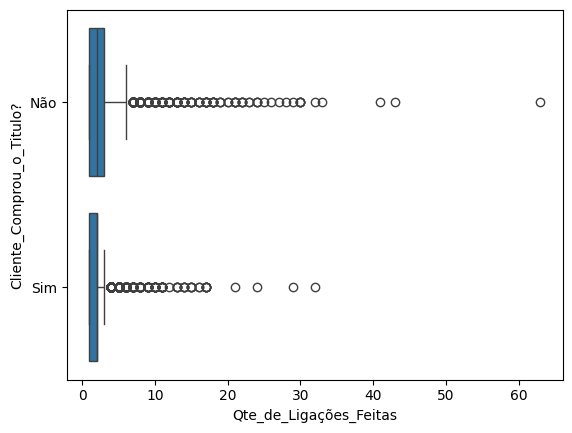

In [10]:
sns.boxplot(data = df_marketing, x="Qte_de_Ligações_Feitas", y="Cliente_Comprou_o_Titulo?")

In [11]:
df_ttest = df_marketing[["Qte_de_Ligações_Feitas", "Cliente_Comprou_o_Titulo?"]].pivot(columns=["Cliente_Comprou_o_Titulo?"], 
                                                                             values = "Qte_de_Ligações_Feitas").fillna(0)

In [12]:
print(df_ttest["Não"].mean(), df_ttest["Sim"].mean())
print(df_ttest["Não"].std(), df_ttest["Sim"].std())
print(df_ttest["Não"].median(), df_ttest["Sim"].median())

1.4215200330441966 1.0419248244527055
2.6471630847971013 1.6955932618047471
1.0 0.0


In [13]:
wilcoxon(df_ttest["Sim"], df_ttest["Não"])

WilcoxonResult(statistic=21446749.5, pvalue=1.7300030174267903e-13)

### Hipótese 2
- Pessoas devedoras, com empréstimos ou com hipotecas tendem a evitar comprar o título

In [14]:
df_h2 = df_marketing[["Cliente_Comprou_o_Titulo?", "Cliente_Devedor?", "Tem_Emprestimo?", "Tem_Hipoteca?"]]

In [15]:
(df_h2.value_counts(normalize=True)
 .reset_index()
 .set_index("Cliente_Comprou_o_Titulo?")
 .sort_values(by = ["Cliente_Comprou_o_Titulo?", "proportion"], ascending=False))

,Cliente_Devedor?,Tem_Emprestimo?,Tem_Hipoteca?,proportion
Cliente_Comprou_o_Titulo?,,,,
Sim,Não,Não,Não,0.302664
Sim,Não,Não,Sim,0.150661
Sim,Não,Sim,Sim,0.020240
Sim,Não,Sim,Não,0.018071
Sim,Sim,Não,Não,0.000826
Sim,Sim,Não,Sim,0.000516
Sim,Sim,Sim,Não,0.000207
Sim,Sim,Sim,Sim,0.000207
Não,Não,Não,Sim,0.239157


In [16]:
df_h2_test = (df_h2.value_counts(normalize=False)
 .reset_index(name = "freq")
 .sort_values(by = ["Cliente_Comprou_o_Titulo?", "freq"], ascending=False)
 )

In [17]:
df_h2_test = df_h2_test.loc[df_h2_test["freq"] >= 1000]
df_h2_test

,Cliente_Comprou_o_Titulo?,Cliente_Devedor?,Tem_Emprestimo?,Tem_Hipoteca?,freq
0,Sim,Não,Não,Não,2931
3,Sim,Não,Não,Sim,1459
1,Não,Não,Não,Sim,2316
2,Não,Não,Não,Não,1806


In [18]:
teste = chi2_contingency(df_h2_test["freq"])

In [19]:
teste.statistic, teste.pvalue

(0.0, 1.0)

### Hipótese 3
- Pessoas com saldo na conta corrente mais altos ou pessoas mais velhas e solteiros tendem a comprar o título

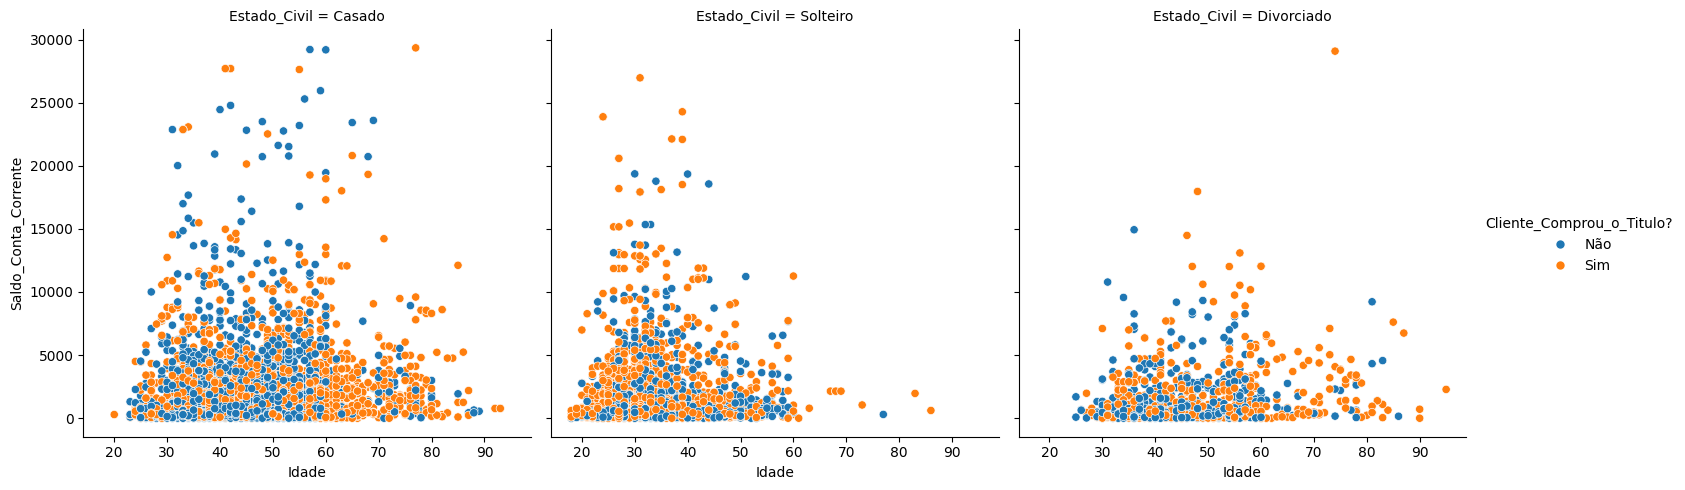

In [34]:
sns.relplot(data = df_marketing, x = "Idade", y = "Saldo_Conta_Corrente", hue = "Cliente_Comprou_o_Titulo?", col = "Estado_Civil")

## Relatório Executivo